In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import random
import os

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR

In [3]:
from my_toolkit.utils.data import datasets
from my_toolkit.utils.data.datasets import DataLoader as MyDataLoader
from my_toolkit.utils.plot import Animator
from my_toolkit.models.DeepSetVarAutoEncoder import ParticleEncoder, AutoEncoder, LossFunc

In [4]:
from torchviz import make_dot
import hiddenlayer as hl

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data preparation

In [6]:
path = '/scratch2/chaoyi/DarkMachines/sm/'
sm_data = MyDataLoader(path)

In [7]:
next(sm_data.next())[0].shape

torch.Size([780, 80])

In [8]:
class my_dataset( Dataset ):
    def __init__( self, kine, particles ):
        self.kine = kine
        self.particles = particles

    def __len__(self):
        return len(self.particles)

    def __getitem__(self, idx):
        return self.kine[idx], self.particles[idx]

In [9]:
def prepare_data(path):
    data_obj = datasets.ReadCSVData(glob.glob(path))
    df = data_obj.data
    missing_obj = np.stack([np.zeros(len(df)), np.log10(df['MET'].values/1000), np.ones(len(df))*(-1), df['METphi'].values], axis=1)
    data = torch.concat([torch.tensor(missing_obj), torch.tensor(data_obj.kin())], axis=1)

    objects = pd.DataFrame(data_obj.objects()).fillna( np.nan ).values
    objects = np.concatenate([np.expand_dims(np.array(['M']*len(df)),axis=1), objects], axis=1)
    objects = np.vstack([np.array(['M','j','b','e-','e+','m-','m+','g',np.nan]*20, dtype='object').reshape(20,9).T, objects])
    objects = pd.DataFrame(objects)
    one_hot_encoded = pd.get_dummies(objects, dummy_na=True)[9:].values

    ready_data = my_dataset(data, torch.tensor(one_hot_encoded))

    return DataLoader( ready_data, batch_size=780, shuffle=True )

In [10]:
np1_loader = prepare_data('/scratch2/chaoyi/DarkMachines/bsm/bsm_10fb/Zp*.csv')
np2_loader = prepare_data('/scratch2/chaoyi/DarkMachines/bsm/bsm_10fb/gluino*.csv')
np3_loader = prepare_data('/scratch2/chaoyi/DarkMachines/training_files/chan1/stop2b1000_neutralino300_chan1.csv')
np4_loader = prepare_data('/scratch2/chaoyi/DarkMachines/bsm_models/simplify_models/type2seesaw_100_100.csv')

# Setup of the model, loss function, and optimizer

In [11]:
model = ParticleEncoder(13, 284, 284, 284, num_outputs=10)
autoencoder = AutoEncoder(model, 20).to(DEVICE)
loss_func = LossFunc(1, 0, 0) 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=4e-4)

In [12]:
params=dict(list(autoencoder.named_parameters()))

In [13]:
train_sample = next(sm_data.next())
kine_input, class_input = train_sample[0].type(torch.float).to(DEVICE), train_sample[1].type(torch.float).to(DEVICE)
event_train_sample = torch.zeros_like(kine_input[:,:1])

for j in range(20):
    event_train_sample = torch.hstack([event_train_sample, kine_input[:,4*j:4*j+4]])
    event_train_sample = torch.hstack([event_train_sample, class_input[:,9*j:9*j+9]])
event_train_sample = event_train_sample[:,1:]

make_dot(autoencoder(event_train_sample), params=params).render("Architecture", format="png")

'Architecture.png'

In [14]:
def eval_loss(data_loader):
    test_sample = next(iter(data_loader))
    kine_input, class_input = test_sample[0].type(torch.float).to(DEVICE), test_sample[1].type(torch.float).to(DEVICE)
    event_test_sample = torch.zeros_like(kine_input[:,:1])
    for k in range(20):
        event_test_sample = torch.hstack([event_test_sample, kine_input[:,4*k:4*k+4]])
        event_test_sample = torch.hstack([event_test_sample, class_input[:,9*k:9*k+9]])
    event_test_sample = event_test_sample[:,1:]
    kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9)        
    mean, log_var, kine_pred, class_pred = autoencoder(event_test_sample)
    total_loss = loss_func(kine_input, class_input, kine_pred, class_pred, mean, log_var)
    return total_loss

# Model training

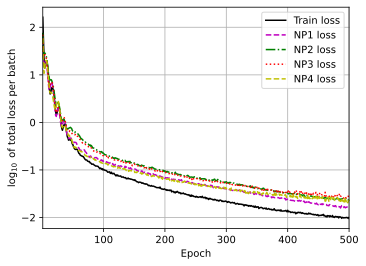

In [15]:
animator = Animator(xlabel='Epoch', ylabel=r'$\log_{10}$ of total loss per batch', xlim=[1, 500], fmts=('-k', 'm--', 'g-.', 'r:', '--y'),
                    legend=['Train loss', 'NP1 loss', 'NP2 loss', 'NP3 loss', 'NP4 loss'],figsize=(5.5, 4))
train_losses = []
np1_losses = []
np2_losses = []
np3_losses = []
np4_losses = []
for i in range(500):
    train_sample = next(sm_data.next()) 
    kine_input, class_input = train_sample[0].type(torch.float).to(DEVICE), train_sample[1].type(torch.float).to(DEVICE)
    event_train_sample = torch.zeros_like(kine_input[:,:1])
    for j in range(20):
        event_train_sample = torch.hstack([event_train_sample, kine_input[:,4*j:4*j+4]])
        event_train_sample = torch.hstack([event_train_sample, class_input[:,9*j:9*j+9]])
    event_train_sample = event_train_sample[:,1:]
    kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9) 
    mean, log_var, kine_pred, class_pred = autoencoder(event_train_sample)
    train_loss = loss_func(kine_input, class_input, kine_pred, class_pred, mean, log_var).sum()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    with torch.no_grad():
        np1_loss = eval_loss(np1_loader).sum()
        np2_loss = eval_loss(np2_loader).sum()
        np3_loss = eval_loss(np3_loader).sum()
        np4_loss = eval_loss(np4_loader).sum()
        
    animator.add(i + 1, [np.log10(train_loss.item()), np.log10(np1_loss.sum().item()), np.log10(np2_loss.item()), np.log10(np3_loss.item()), np.log10(np4_loss.item())])
    if i%10 == 0: 
        train_losses.append(train_loss.item()/780)
        np1_losses.append(np1_loss.item()/780)
        np2_losses.append(np2_loss.item()/780)
        np3_losses.append(np3_loss.item()/780)
        np4_losses.append(np4_loss.item()/780)
        print('train mean loss: ', train_losses)
        print('NP1 mean loss: ',  np1_losses)
        print('NP2 mean loss: ',  np2_losses)
        print('NP3 mean loss: ',  np3_losses)
        print('NP4 mean loss: ',  np4_losses)

# Model parameters

In [16]:
# torch.save(autoencoder.state_dict(), '../model_pars/DeepSetVAE_beta0.5_w10.pth')
# autoencoder.load_state_dict(torch.load('../model_pars/DeepSetVAE_beta1_w1.pth'))
# autoencoder.eval()

# Comparison of samples in the latent space 

In [17]:
folders = sm_data.folders

In [18]:
def eval_sample(data_loader):
    test_sample = next(iter(data_loader))
    kine_input, class_input = test_sample[0].type(torch.float).to(DEVICE), test_sample[1].type(torch.float).to(DEVICE)
    event_test_sample = torch.zeros_like(kine_input[:,:1])
    for k in range(20):
        event_test_sample = torch.hstack([event_test_sample, kine_input[:,4*k:4*k+4]])
        event_test_sample = torch.hstack([event_test_sample, class_input[:,9*k:9*k+9]])
    event_test_sample = event_test_sample[:,1:]
    kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9)        
    samples = autoencoder.encoder(event_test_sample)[2]
    return samples

In [19]:
sm_samples = {}
for i in folders:
    process = i.split('/')[-1]
    files = glob.glob(i+'/*csv')
    file_path = files[np.random.randint(len(files))]
    data_loader = prepare_data(file_path)
    with torch.no_grad():
        samples = eval_sample(data_loader)
        sm_samples[process] = samples

In [20]:
bsm_samples = {}
bsm_path = '/scratch2/chaoyi/DarkMachines/training_files/'
bsm_files = [bsm_path+'chan1/stop2b1000_neutralino300_chan1.csv', bsm_path+'chan1/monojet_Zp2000.0_DM_50.0_chan1.csv', 
             bsm_path+'chan1/sqsq1_sq1400_neut800_chan1.csv', bsm_path+'chan1/sqsq_sq1800_neut800_chan1.csv', 
             bsm_path+'chan2a/gluino_1000.0_neutralino_1.0_chan2a.csv', bsm_path+'chan2a/chaneut_cha400_neut200_chan2a.csv']
bsm_processes = ['stop2b1000', 'monojet_Zp2000', 'sqsq1_sq1400', 'sqsq_sq1800', 'gluino_1000', 'chaneut_cha400']
for file_path, process in zip(bsm_files, bsm_processes):
    data_loader = prepare_data(file_path)
    with torch.no_grad():
        samples = eval_sample(data_loader)
        bsm_samples[process] = samples

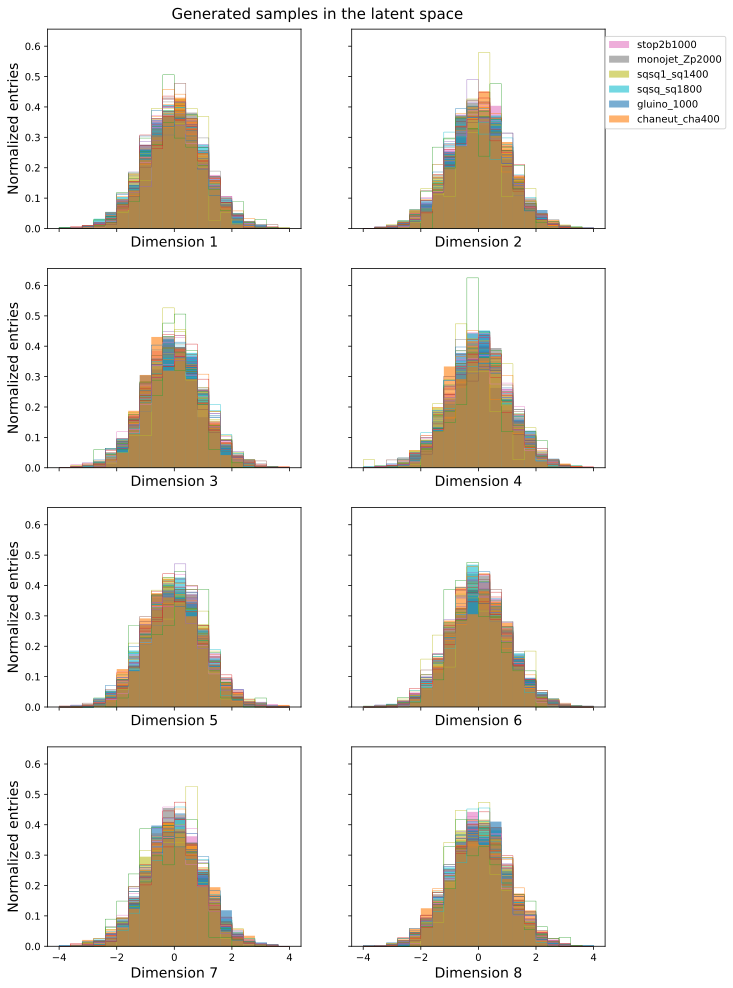

In [21]:
fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(10, 15))
fig.subplots_adjust(top=0.96)
fig.suptitle('Generated samples in the latent space', fontsize=15)
sm_accumulator = {key: torch.empty(0) for key in range(8)}
bsm_accumulator = {key: torch.empty(0) for key in range(8)}
binning = np.linspace(-4, 4, 21)

for i_dim in range(8):  
    index = int(i_dim/2), i_dim%2
    if index[1]==0:
        ax[index].set_ylabel('Normalized entries', size=14)
    ax[index].set_xlabel(f'Dimension {i_dim+1}', size=14)
    for i in sm_samples.keys():
        ax[index].hist(sm_samples[i][:,i_dim].cpu(), binning, histtype='step', lw=0.4, density=1)
        sm_accumulator[i_dim] = torch.cat([sm_accumulator[i_dim], sm_samples[i][:,i_dim].cpu()])
    for i in bsm_samples.keys():
        ax[index].hist(bsm_samples[i][:,i_dim].cpu(), binning, label=i, density=1, alpha=0.6)
        bsm_accumulator[i_dim] = torch.cat([bsm_accumulator[i_dim], bsm_samples[i][:,i_dim].cpu()])
ax[0,1].legend(loc=(1, 0.5))
plt.show()

In [22]:
for i in range(8):
    print(f' {i+1}-th dimension:', '\n',
          'SM Mean: {:.3f} \t'.format(sm_accumulator[i].mean().numpy()),
          'Std: {:.3f}'.format(sm_accumulator[i].std().numpy()), '\n',
          'BSM Mean: {:.3f} \t'.format(bsm_accumulator[i].mean().numpy()),
          'Std: {:.3f}'.format(bsm_accumulator[i].std().numpy()), '\n',
          '----------------------------------')

 1-th dimension: 
 SM Mean: 0.009 	 Std: 1.003 
 BSM Mean: -0.008 	 Std: 1.004 
 ----------------------------------
 2-th dimension: 
 SM Mean: -0.004 	 Std: 0.993 
 BSM Mean: 0.007 	 Std: 1.011 
 ----------------------------------
 3-th dimension: 
 SM Mean: -0.005 	 Std: 0.999 
 BSM Mean: -0.031 	 Std: 0.977 
 ----------------------------------
 4-th dimension: 
 SM Mean: -0.000 	 Std: 1.011 
 BSM Mean: 0.012 	 Std: 1.007 
 ----------------------------------
 5-th dimension: 
 SM Mean: -0.004 	 Std: 0.998 
 BSM Mean: 0.004 	 Std: 0.996 
 ----------------------------------
 6-th dimension: 
 SM Mean: -0.013 	 Std: 0.997 
 BSM Mean: 0.019 	 Std: 1.006 
 ----------------------------------
 7-th dimension: 
 SM Mean: -0.017 	 Std: 0.996 
 BSM Mean: -0.012 	 Std: 0.989 
 ----------------------------------
 8-th dimension: 
 SM Mean: -0.002 	 Std: 1.001 
 BSM Mean: -0.002 	 Std: 0.987 
 ----------------------------------


# Comparison of loss

In [23]:
sm_samples = {}
for i in folders:
    process = i.split('/')[-1]
    files = glob.glob(i+'/*csv')
    file_path = files[np.random.randint(len(files))]
    sm_loader = prepare_data(file_path)
    with torch.no_grad():
        loss = eval_loss(sm_loader)
        sm_samples[process] = loss

In [24]:
bsm_samples = {}
for file_path, process in zip(bsm_files, bsm_processes):
    bsm_loader = prepare_data(file_path)
    with torch.no_grad():
        loss = eval_loss(bsm_loader)
        bsm_samples[process] = loss

/home/chaoyi/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


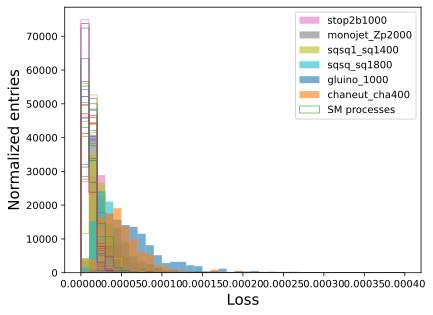

In [25]:
binning = np.linspace(0, 4e-4, 41)

for i in sm_samples.keys():
    plt.hist(sm_samples[i].cpu().numpy(), binning, histtype='step', density=1, lw=0.6)
for i in bsm_samples.keys():
    plt.hist(bsm_samples[i].cpu().numpy(), binning, label=i, density=1, alpha=0.6)
plt.hist([-1], binning, histtype='step', density=1, lw=0.6, label='SM processes')
plt.legend()
plt.xlabel('Loss', size=15)
plt.ylabel('Normalized entries', size=15)
plt.show()

### Loss decomposition

In [26]:
def eval_indi_loss(data_loader):
    test_sample = next(iter(data_loader))
    kine_input, class_input = test_sample[0].type(torch.float).to(DEVICE), test_sample[1].type(torch.float).to(DEVICE)
    event_test_sample = torch.zeros_like(kine_input[:,:1])
    for k in range(20):
        event_test_sample = torch.hstack([event_test_sample, kine_input[:,4*k:4*k+4]])
        event_test_sample = torch.hstack([event_test_sample, class_input[:,9*k:9*k+9]])
    event_test_sample = event_test_sample[:,1:]
    kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9)        
    mean, log_var, kine_pred, class_pred = autoencoder(event_test_sample)
    chamfer_loss, *indxs = loss_func.ChamferLoss(kine_input, kine_pred)
    class_loss = loss_func.ClassLoss(class_input, class_pred, indxs)
    kl_loss = loss_func.KLDivergence(mean, log_var)
    classnum_loss = loss_func.ClassNumLoss(class_input, class_pred)
    return ((1-loss_func.beta)*chamfer_loss).mean().cpu().detach().numpy(), ((1-loss_func.beta)*loss_func.w*class_loss).mean().cpu().detach().numpy(), ((1-loss_func.beta)*loss_func.c*classnum_loss).mean().cpu().detach().numpy(), (loss_func.beta*kl_loss).mean().cpu().detach().numpy()

In [27]:
print(' SM results: \n Chamfer loss: {:.2E} \n Classification loss: {:.2E} \n Number of particles loss: {:.2E} \n KL divergence: {:.2E}'.format(*eval_indi_loss(sm_loader)))

 SM results: 
 Chamfer loss: 0.00E+00 
 Classification loss: 0.00E+00 
 Number of particles loss: 0.00E+00 
 KL divergence: 1.56E-05


In [28]:
print(' BSM results: \n Chamfer loss: {:.2E} \n Classification loss: {:.2E} \n Number of particles loss: {:.2E} \n KL divergence: {:.2E}'.format(*eval_indi_loss(bsm_loader)))

 BSM results: 
 Chamfer loss: 0.00E+00 
 Classification loss: 0.00E+00 
 Number of particles loss: 0.00E+00 
 KL divergence: 6.01E-05


# Comparison of input objects and reconstructed objects

In [29]:
test_sample = next(iter(data_loader))
kine_input, class_input = test_sample[0].type(torch.float).to(DEVICE), test_sample[1].type(torch.float).to(DEVICE)
event_test_sample = torch.zeros_like(kine_input[:,:1])
for k in range(20):
    event_test_sample = torch.hstack([event_test_sample, kine_input[:,4*k:4*k+4]])
    event_test_sample = torch.hstack([event_test_sample, class_input[:,9*k:9*k+9]])
event_test_sample = event_test_sample[:,1:]
kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9)        
mean, log_var, kine_pred, class_pred = autoencoder(event_test_sample)

In [30]:
_, idx1, _ = loss_func.ChamferLoss(kine_input, kine_pred)
sorted_pred = torch.zeros_like(class_pred)
for i in range(idx1.shape[0]):
    for j in range(idx1.shape[1]):
        sorted_pred[i,j,:] = class_pred[i,idx1[i,j],:]

In [31]:
obj_list = ['MET', 'b jet', r'$e^+$', r'$e^-$', r'$\gamma$', r'jet', r'$\mu^+$', r'$\mu^-$', 'Nan']
one_hot_list = torch.eye(9).tolist()
color_list = ['b', 'r', 'k', 'y', 'g', 'c', 'm', 'gray', 'pink']

In [32]:
plt_config = {}
for i in range(9):
    plt_config[str(one_hot_list[i])] = obj_list[i], color_list[i]

In [33]:
input_dict = {}
for i in torch.eye(9):
    match = class_input[0].cpu() == i
    indx = match.sum(axis=1) == 9
    input_dict[str(i.tolist())] = kine_input[0].cpu()[indx]

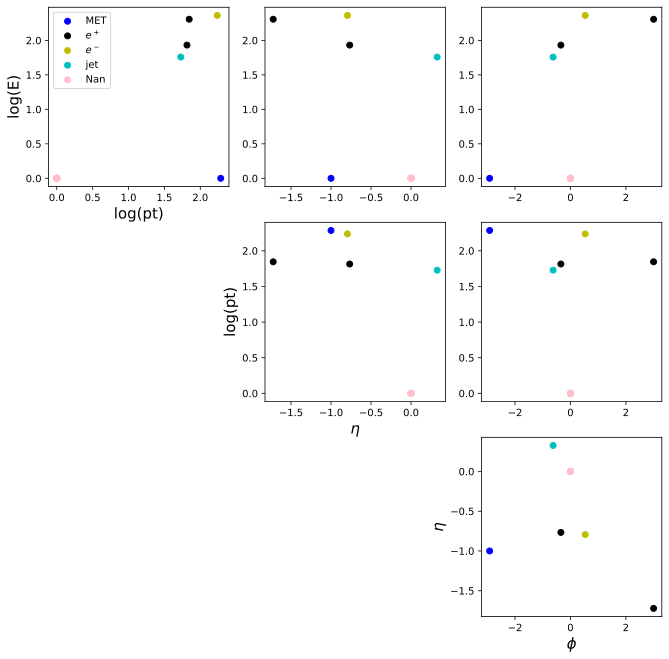

In [34]:
fig, ax = plt.subplots(3,3, figsize=(11, 11)) #, sharex=True, sharey=True
for i in torch.eye(9): 
    if input_dict[str(i.tolist())].tolist():
        kin_i = input_dict[str(i.tolist())]
        ax[0,0].scatter(kin_i[:,1], kin_i[:,0], color=plt_config[str(i.tolist())][1], label=plt_config[str(i.tolist())][0])
        ax[0,1].scatter(kin_i[:,2], kin_i[:,0], color=plt_config[str(i.tolist())][1])
        ax[0,2].scatter(kin_i[:,3], kin_i[:,0], color=plt_config[str(i.tolist())][1])
        ax[1,1].scatter(kin_i[:,2], kin_i[:,1], color=plt_config[str(i.tolist())][1])
        ax[1,2].scatter(kin_i[:,3], kin_i[:,1], color=plt_config[str(i.tolist())][1])
        ax[2,2].scatter(kin_i[:,3], kin_i[:,2], color=plt_config[str(i.tolist())][1])
ax[0,0].legend()
ax[0,0].set_ylabel('log(E)',size=15)
ax[0,0].set_xlabel('log(pt)',size=15)
ax[1,1].set_ylabel('log(pt)',size=15)
ax[1,1].set_xlabel(r'$\eta$',size=15)
ax[2,2].set_ylabel(r'$\eta$',size=15)
ax[2,2].set_xlabel(r'$\phi$',size=15)
ax[1,0].set_visible(False)
ax[2,0].set_visible(False)
ax[2,1].set_visible(False)
plt.show()

In [35]:
indx = torch.max(torch.exp(sorted_pred[0]),axis=1)[-1]
onehot_pred = torch.empty(20,9)
iden_mat = torch.eye(9)
for i, j in enumerate(indx):
    onehot_pred[i] = iden_mat[j]

In [36]:
pred_dict = {}
for i in torch.eye(9):
    match = onehot_pred.cpu() == i
    indx = match.sum(axis=1) == 9
    pred_dict[str(i.tolist())] = kine_pred[0].cpu()[indx]

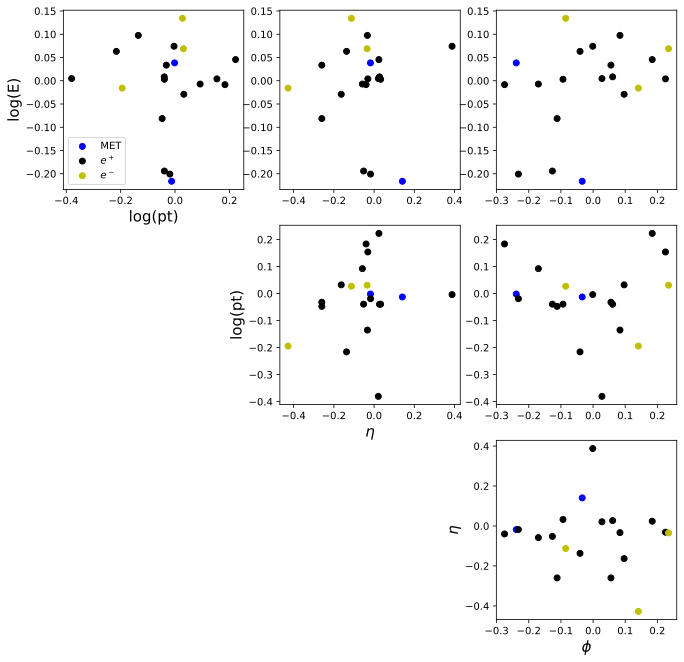

In [37]:
fig, ax = plt.subplots(3,3, figsize=(11, 11)) #sharex=True, sharey=True, 
for i in torch.eye(9): 
    if pred_dict[str(i.tolist())].tolist():
        kin_i = pred_dict[str(i.tolist())].detach()
        ax[0,0].scatter(kin_i[:,1], kin_i[:,0], color=plt_config[str(i.tolist())][1], label=plt_config[str(i.tolist())][0])
        ax[0,1].scatter(kin_i[:,2], kin_i[:,0], color=plt_config[str(i.tolist())][1])
        ax[0,2].scatter(kin_i[:,3], kin_i[:,0], color=plt_config[str(i.tolist())][1])
        ax[1,1].scatter(kin_i[:,2], kin_i[:,1], color=plt_config[str(i.tolist())][1])
        ax[1,2].scatter(kin_i[:,3], kin_i[:,1], color=plt_config[str(i.tolist())][1])
        ax[2,2].scatter(kin_i[:,3], kin_i[:,2], color=plt_config[str(i.tolist())][1])
ax[0,0].legend()
ax[0,0].set_ylabel('log(E)',size=15)
ax[0,0].set_xlabel('log(pt)',size=15)
ax[1,1].set_ylabel('log(pt)',size=15)
ax[1,1].set_xlabel(r'$\eta$',size=15)
ax[2,2].set_ylabel(r'$\eta$',size=15)
ax[2,2].set_xlabel(r'$\phi$',size=15)
ax[1,0].set_visible(False)
ax[2,0].set_visible(False)
ax[2,1].set_visible(False)
plt.show()